# Тестовое задание

## Соглашения  и изменения в данных

<ol>
    <li>Выбран диапазон для исследования с 10.10.2020 по 10.11.2020</li>
    <li>Согласовано: отбросить данные клиентов со временем регистрации равным '0001-01-01 00:00:00' (теряем 29215 записей 61.44 % от общего количества)</li>
    <li>Согласовано: отбросить лиды с идентификаторами менеджеров, отсутствующими в таблице менеджеров (теряем 566 записей 83.04 % от общего количества за исследуемый период)</li>
    <li>Согласовано: для клиентов, имеющих несколько лидов в указанный период, новых клиентов рассчитываем по первому лиду</li>
    <li>Замена синонимов в источниках лидов vk->vkontakte, insta->instagram, пустых и равных "utm_source"  на "Не указано"</li>
</ol>

*приведенные значения потерь не пересчитываются - действительны только за выбранный период

## Импорт данных

In [1]:
import gspread
import pandas as pd
import numpy as np
import datetime as dt
import time

#файл с закрытым ключом
CREDENTIALS_FILE = 'testproject260521-496b2b96ea1c.json' 

#Дата начала периода
START_DATE = '2020-10-10'

#Дата окончания периода
END_DATE = '2020-11-10'

# Указываем путь к JSON
gc = gspread.service_account(filename=CREDENTIALS_FILE)

#Открываем тестовую таблицу
table = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Ycg7zTxds9DZnDvTrFcyNNKuTUxg6Yy6WF0a8Wc02WQ')

In [2]:
#листы в документе

sheets = table.worksheets()
for i in range(len(sheets)):
    print (i, sheets[i])

0 <Worksheet 'Легенда' id:0>
1 <Worksheet 'transactions' id:1164376473>
2 <Worksheet 'clients' id:1840297911>
3 <Worksheet 'managers' id:897421023>
4 <Worksheet 'leads' id:1167027454>


In [3]:
#создаем фреймы данных


#транзакции
tmp = sheets[1].get_all_values()
transactions = pd.DataFrame(data=tmp[1:])
transactions.columns = tmp[0]

#клиенты
tmp = sheets[2].get_all_values()
clients = pd.DataFrame(data=tmp[1:])
clients.columns = tmp[0]

#менеджеры
tmp = sheets[3].get_all_values()
managers = pd.DataFrame(data=tmp[1:])
managers.columns = tmp[0]

#лиды
tmp = sheets[4].get_all_values()
leads = pd.DataFrame(data=tmp[1:])
leads.columns = tmp[0]

## Предобработка данных

Клиенты

In [4]:
clients

,client_id,created_at,l_manager_id
0,0001da7d-fcda-11ea-ac18-c412f533dba1,2020-09-22 17:46:23,9a87c608-52dc-11ea-abeb-c412f533dba1
1,000a8743-9ae1-11e7-8114-c412f533dba1,2017-09-16 00:00:00,ad52c7a8-a752-11e7-8115-c412f533dba1
2,000ae57e-2d48-11ea-abeb-c412f533dba1,2020-01-02 14:08:56,43756fa4-57a0-11e9-ab9a-c412f533dba1
3,00133cde-481c-11ea-abeb-c412f533dba1,2020-02-05 17:25:13,9a87c608-52dc-11ea-abeb-c412f533dba1
4,00148d3f-07e6-11e8-812a-c412f533dba1,2018-02-02 00:00:00,abed5496-ca88-11e9-abb8-c412f533dba1
...,...,...,...
75761,ffeed40c-3a7e-11e9-ab8e-c412f533dba1,2019-02-27 00:00:00,db06b8bc-bfb2-11e7-8116-c412f533dba1
75762,fff022a5-2c34-11e8-8131-c412f533dba1,2018-03-20 00:00:00,d12fe765-b444-11e9-abb3-c412f533dba1
75763,fff88086-11bb-11ea-abe7-c412f533dba1,2019-11-28 12:48:58,bf340611-034b-11eb-ac18-c412f533dba1
75764,fff9ba6e-de05-11e9-abc1-c412f533dba1,2019-09-23 17:27:42,43756fa4-57a0-11e9-ab9a-c412f533dba1


In [5]:
clients_before_size = clients.shape[0]

#отбросим записи с некорректной датой
clients = clients[clients.created_at!='0001-01-01 00:00:00']

clients_new_size = clients.shape[0]

print("Удалено " + str(clients_before_size-clients_new_size) + ' записей (' + str(round(clients_new_size/clients_before_size * 100,2)) + ' % от общего количества)')

Удалено 29215 записей (61.44 % от общего количества)


In [6]:
#Приведем дату к соответствующему формату.
clients.created_at = pd.to_datetime(clients.created_at)

d:\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Каналы привлечения

In [7]:
leads

,lead_id,created_at,d_utm_medium,d_utm_source,l_manager_id,l_client_id
0,00678e71-0fb9-11eb-ac1a-c412f533dba1,2020-10-16 18:08:09,sms,viber,1e9c5562-0cfc-11ea-abe1-c412f533dba1,7264cf21-a31d-11e9-abb0-c412f533dba1
1,0078b05d-0f1f-11eb-ac1a-c412f533dba1,2020-10-15 23:45:40,cpc,instagram,d12fe765-b444-11e9-abb3-c412f533dba1,606c5b29-0f88-11eb-ac1a-c412f533dba1
2,007d1401-2af3-11eb-ac1f-c412f533dba1,2020-11-20 09:41:14,cpc,instagram,43756fa4-57a0-11e9-ab9a-c412f533dba1,1f389c6a-d5ab-11e9-abbe-c412f533dba1
3,0084e614-2fcc-11eb-ac1f-c412f533dba1,2020-11-26 13:44:40,,,00000000-0000-0000-0000-000000000000,00000000-0000-0000-0000-000000000000
4,009b1616-145d-11eb-ac1d-c412f533dba1,2020-10-22 15:52:04,cpc,vk,5dd88f32-6501-11ea-abf3-c412f533dba1,ac2c0012-6fd5-11e7-80fc-c412f533dba1
...,...,...,...,...,...,...
3332,ffaa0815-16c4-11eb-ac1d-c412f533dba1,2020-10-25 17:21:33,,,5dd88f32-6501-11ea-abf3-c412f533dba1,ffaa0816-16c4-11eb-ac1d-c412f533dba1
3333,ffacb5af-194f-11eb-ac1d-c412f533dba1,2020-10-28 23:01:35,cpc,vk,ad52c7a8-a752-11e7-8115-c412f533dba1,377ea5e0-d089-11e9-abbd-c412f533dba1
3334,ffbd53f1-3150-11eb-ac1f-c412f533dba1,2020-11-28 12:09:13,cpc,google,5dd88f32-6501-11ea-abf3-c412f533dba1,6dd39f15-d5a3-11e9-abbe-c412f533dba1
3335,ffc0b363-2ae9-11eb-ac1f-c412f533dba1,2020-11-20 08:36:48,cpc,instagram,ad52c7a8-a752-11e7-8115-c412f533dba1,00000000-0000-0000-0000-000000000000


Приведем дату к соответствующему формату.

In [8]:
leads.created_at = pd.to_datetime(leads.created_at)

Оставим информацию за интересующий период

In [9]:
leads = leads[(leads.created_at>=START_DATE)&(leads.created_at<=END_DATE)]

Посмотрим на источник лидов

In [10]:
leads.d_utm_source.unique()

array(['viber', 'instagram', 'vk', '', 'utm_source', 'insta', 'google',
       'yandex', 'sms', 'vkontakte', 'ycard'], dtype=object)

Приведем синонимы наименований, очистим поля со значением "utm_source"

In [11]:
leads.loc[leads.d_utm_source=='vk', 'd_utm_source'] = 'vkontakte'
leads.loc[leads.d_utm_source=='insta', 'd_utm_source'] = 'instagram'
leads.loc[leads.d_utm_source=='utm_source', 'd_utm_source'] = 'Не указано'
leads.loc[leads.d_utm_source=='', 'd_utm_source'] = 'Не указано'

d:\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
#соединим таблицы leads и managers  по идентификатору менеджера
leads_left = pd.merge(leads, managers, how='left', left_on='l_manager_id', right_on='manager_id', copy=False)
leads_left_join_size = leads_left.shape[0]

leads = pd.merge(leads, managers, how='inner', left_on='l_manager_id', right_on='manager_id', copy=False)
leads_inner_join_size = leads.shape[0]

print('При соединении inner теряем ' + str(leads_left_join_size-leads_inner_join_size) + ' записей (' + str(round(leads_inner_join_size/leads_left_join_size * 100,2)) + ' % от общего количества)')

При соединении inner теряем 177 записей (89.82 % от общего количества)


In [13]:
print("Уникальных значений по полю lead_id:" + str(leads.lead_id.nunique()) + " из " + str(leads.shape[0]))
print("Уникальных значений по полю l_client_id:" + str(leads.l_client_id.nunique()) + " из " + str(leads.shape[0]))

Уникальных значений по полю lead_id:1561 из 1561
Уникальных значений по полю l_client_id:1240 из 1561


In [14]:
duplicated_leads = leads[leads.l_client_id.map(leads.groupby('l_client_id')['l_client_id'].count()>1)].sort_values('l_client_id')
duplicated_leads.groupby('l_client_id')['l_client_id'].count()

l_client_id
00000000-0000-0000-0000-000000000000    162
063c88ef-176b-11eb-ac1d-c412f533dba1      3
06787e1d-6fd6-11e7-80fc-c412f533dba1      2
07898c7a-0acb-11eb-ac1a-c412f533dba1      2
0c042443-183b-11eb-ac1d-c412f533dba1      2
                                       ... 
f830407f-6fd7-11e7-80fc-c412f533dba1      3
f83040aa-6fd7-11e7-80fc-c412f533dba1      2
f96883a0-c925-11e7-811c-c412f533dba1      2
fbd6befb-15bf-11eb-ac1d-c412f533dba1      2
fccb8337-f045-11ea-ac18-c412f533dba1      2
Name: l_client_id, Length: 129, dtype: int64

Наибольшее количество дублей у клиента с id 00000000-0000-0000-0000-000000000000 - вероятно это и есть "мусорные заявки "

In [15]:
duplicated_leads_interval = duplicated_leads[duplicated_leads.l_client_id!='00000000-0000-0000-0000-000000000000'].groupby('l_client_id')['created_at'].agg([min, max])
duplicated_leads_interval['interval'] = duplicated_leads_interval['max'] - duplicated_leads_interval['min']
duplicated_leads_interval = duplicated_leads_interval.sort_values('interval', ascending=False)
duplicated_leads_interval

,min,max,interval
l_client_id,,,
5f5a5203-0d45-11eb-ac1a-c412f533dba1,2020-10-10 22:16:49,2020-11-03 11:48:10,23 days 13:31:21
d6f9b135-03ac-11eb-ac18-c412f533dba1,2020-10-14 07:28:21,2020-11-06 15:17:33,23 days 07:49:12
c2cd1c76-32be-11ea-abeb-c412f533dba1,2020-10-19 23:01:15,2020-11-09 16:13:19,20 days 17:12:04
eaa2ca10-6fd6-11e7-80fc-c412f533dba1,2020-10-16 13:31:59,2020-11-04 07:57:48,18 days 18:25:49
1a8258b2-6fd7-11e7-80fc-c412f533dba1,2020-10-19 15:49:11,2020-11-06 18:27:06,18 days 02:37:55
...,...,...,...
c930763f-d5a5-11e9-abbe-c412f533dba1,2020-11-07 17:46:35,2020-11-07 17:46:35,0 days 00:00:00
3f7f4a04-e76f-11e9-abd7-c412f533dba1,2020-11-08 16:49:52,2020-11-08 16:49:52,0 days 00:00:00
35be576d-d5a8-11e9-abbe-c412f533dba1,2020-11-07 17:46:18,2020-11-07 17:46:18,0 days 00:00:00


<AxesSubplot:>

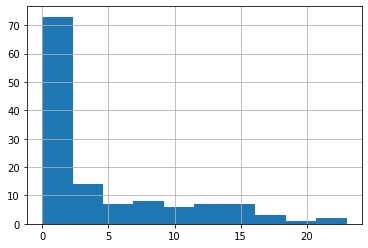

In [16]:
duplicated_leads_interval.interval.dt.days.hist()

In [17]:
leads

,lead_id,created_at,d_utm_medium,d_utm_source,l_manager_id,l_client_id,manager_id,d_manager,d_club
0,00678e71-0fb9-11eb-ac1a-c412f533dba1,2020-10-16 18:08:09,sms,viber,1e9c5562-0cfc-11ea-abe1-c412f533dba1,7264cf21-a31d-11e9-abb0-c412f533dba1,1e9c5562-0cfc-11ea-abe1-c412f533dba1,manager #8,club #2
1,02554de5-12c9-11eb-ac1c-c412f533dba1,2020-10-20 15:40:11,sms,viber,1e9c5562-0cfc-11ea-abe1-c412f533dba1,214a6764-d5ae-11e9-abbe-c412f533dba1,1e9c5562-0cfc-11ea-abe1-c412f533dba1,manager #8,club #2
2,028dc5b3-1852-11eb-ac1d-c412f533dba1,2020-10-27 16:43:28,cpc,instagram,1e9c5562-0cfc-11ea-abe1-c412f533dba1,50010dbc-03c2-11ea-abdf-c412f533dba1,1e9c5562-0cfc-11ea-abe1-c412f533dba1,manager #8,club #2
3,02df5b28-12aa-11eb-ac1c-c412f533dba1,2020-10-20 11:58:20,sms,viber,1e9c5562-0cfc-11ea-abe1-c412f533dba1,8520501c-f5e8-11e7-8126-c412f533dba1,1e9c5562-0cfc-11ea-abe1-c412f533dba1,manager #8,club #2
4,03a8d983-186b-11eb-ac1d-c412f533dba1,2020-10-27 19:42:34,,Не указано,1e9c5562-0cfc-11ea-abe1-c412f533dba1,03a8d984-186b-11eb-ac1d-c412f533dba1,1e9c5562-0cfc-11ea-abe1-c412f533dba1,manager #8,club #2
...,...,...,...,...,...,...,...,...,...
1556,42335ec1-0d1e-11eb-ac1a-c412f533dba1,2020-10-13 10:35:25,,Не указано,543888c4-fbb3-11e9-abdc-c412f533dba1,42335ebf-0d1e-11eb-ac1a-c412f533dba1,543888c4-fbb3-11e9-abdc-c412f533dba1,manager #12,club #3
1557,4f854cc8-1e80-11eb-ac1d-c412f533dba1,2020-11-04 13:30:01,,Не указано,543888c4-fbb3-11e9-abdc-c412f533dba1,41e93d15-d5ab-11e9-abbe-c412f533dba1,543888c4-fbb3-11e9-abdc-c412f533dba1,manager #12,club #3
1558,76b375c5-2282-11eb-ac1d-c412f533dba1,2020-11-09 15:55:31,cpi,viber,543888c4-fbb3-11e9-abdc-c412f533dba1,0d1e19e9-41ee-11ea-abeb-c412f533dba1,543888c4-fbb3-11e9-abdc-c412f533dba1,manager #12,club #3
1559,795568da-1ab4-11eb-ac1d-c412f533dba1,2020-10-30 17:33:20,,Не указано,543888c4-fbb3-11e9-abdc-c412f533dba1,d1a25b9f-d5ad-11e9-abbe-c412f533dba1,543888c4-fbb3-11e9-abdc-c412f533dba1,manager #12,club #3


### количество заявок

In [18]:
leads_count = leads.groupby(['d_utm_source', 'd_club', 'd_manager'])['lead_id'].count()
leads_count

d_utm_source  d_club   d_manager  
google        club #1  manager #1     11
                       manager #7      3
              club #2  manager #10     7
                       manager #4      4
                       manager #8      5
                                      ..
Не указано    club #3  manager #13    63
                       manager #9     73
              club #4  manager #11    75
                       manager #2     45
                       manager #5     80
Name: lead_id, Length: 67, dtype: int64

In [19]:
total_leads_count = sum(leads_count)
print('Всего заявок: ' + str(total_leads_count))

Всего заявок: 1561


### количество мусорных заявок (на основании заявки не создан клиент)

In [20]:
trash_count = leads[~leads.l_client_id.isin(clients.client_id)].groupby(['d_utm_source', 'd_club', 'd_manager'])['lead_id'].count()
trash_count

d_utm_source  d_club   d_manager  
google        club #1  manager #1      5
                       manager #7      1
              club #3  manager #13     3
                       manager #9      6
              club #4  manager #11     3
                       manager #2      1
                       manager #5      1
instagram     club #1  manager #1     27
                       manager #7      7
              club #2  manager #10     1
                       manager #4      6
                       manager #8      3
              club #3  manager #13    13
                       manager #9     13
              club #4  manager #11    11
                       manager #2      2
                       manager #5     10
viber         club #1  manager #1      3
                       manager #7      2
              club #2  manager #4      1
                       manager #8      1
              club #3  manager #13     1
                       manager #9     18
              club #4 

In [21]:
total_trash_count = sum(trash_count)
print('Всего "мусорных" заявок: ' + str(total_trash_count) + ' (' + str(round(total_trash_count / total_leads_count * 100, 2)) + '%)')

Всего "мусорных" заявок: 295 (18.9%)


### количество новых заявок (не было заявок и покупок от этого клиента 

In [22]:
#Приведем данные к соответствующему типу
transactions.created_at = pd.to_datetime(transactions.created_at)
transactions.m_real_amount = transactions.m_real_amount.astype('int32')

Для всех лидов добавим признак наличия заказов по соответствующему l_client_id

In [23]:
#маркируем лиды без заявок
leads.loc[~leads.l_client_id.isin(transactions.l_client_id.unique()),'new'] = 'wo_transaction'

In [24]:
#объединим данные лидов с транзакциями
leads_transactions = pd.merge(leads, transactions, how='inner', left_on='l_client_id', right_on='l_client_id', copy=False).sort_values(['l_client_id', 'created_at_y'])
leads_transactions

,lead_id,created_at_x,d_utm_medium,d_utm_source,l_manager_id,l_client_id,manager_id,d_manager,d_club,new,transaction_id,created_at_y,m_real_amount
1066,097ba3bf-0ac7-11eb-ac1a-c412f533dba1,2020-10-10 11:05:54,utm_medium,Не указано,abed5496-ca88-11e9-abb8-c412f533dba1,01001c83-0acb-11eb-ac1a-c412f533dba1,abed5496-ca88-11e9-abb8-c412f533dba1,manager #5,club #4,NaN,b1359beb-305a-40b9-b94f-d2495beac61c,2020-10-30 08:15:34,66871
500,d77f4666-12cd-11eb-ac1c-c412f533dba1,2020-10-20 16:14:46,sms,viber,db06b8bc-bfb2-11e7-8116-c412f533dba1,0118a824-6084-11ea-abf3-c412f533dba1,db06b8bc-bfb2-11e7-8116-c412f533dba1,manager #4,club #2,NaN,baf50bf6-18c6-4eb2-ac20-79e147cd9238,2020-03-07 16:14:57,830
499,d77f4666-12cd-11eb-ac1c-c412f533dba1,2020-10-20 16:14:46,sms,viber,db06b8bc-bfb2-11e7-8116-c412f533dba1,0118a824-6084-11ea-abf3-c412f533dba1,db06b8bc-bfb2-11e7-8116-c412f533dba1,manager #4,club #2,NaN,b52645bc-0862-44cb-9d0d-d8b2176a7621,2020-03-07 16:16:38,779
1103,6b401079-2064-11eb-ac1d-c412f533dba1,2020-11-06 23:15:24,cpc,instagram,abed5496-ca88-11e9-abb8-c412f533dba1,015ec0fa-20c8-11eb-ac1d-c412f533dba1,abed5496-ca88-11e9-abb8-c412f533dba1,manager #5,club #4,NaN,018c980a-19f9-421c-bcfb-945c85126f26,2020-11-27 14:50:05,21081
602,b2713527-0d7f-11eb-ac1a-c412f533dba1,2020-10-13 22:12:47,utm_medium,Не указано,43756fa4-57a0-11e9-ab9a-c412f533dba1,02dbcdf7-0969-11eb-ac1a-c412f533dba1,43756fa4-57a0-11e9-ab9a-c412f533dba1,manager #11,club #4,NaN,b74a9c3b-5e32-4b04-9a97-22ce7a8be76d,2020-10-29 09:01:23,55286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,6c9cb3ff-0f6e-11eb-ac1a-c412f533dba1,2020-10-16 09:14:16,cpc,instagram,d12fe765-b444-11e9-abb3-c412f533dba1,fe54aa45-0f8d-11eb-ac1a-c412f533dba1,d12fe765-b444-11e9-abb3-c412f533dba1,manager #1,club #1,NaN,839664c2-6f15-4beb-9b37-4fd55a212f51,2020-10-31 11:42:01,6076
198,6c9cb3ff-0f6e-11eb-ac1a-c412f533dba1,2020-10-16 09:14:16,cpc,instagram,d12fe765-b444-11e9-abb3-c412f533dba1,fe54aa45-0f8d-11eb-ac1a-c412f533dba1,d12fe765-b444-11e9-abb3-c412f533dba1,manager #1,club #1,NaN,33ec202b-60d2-4585-85db-5712d309f117,2020-11-18 15:46:57,5827
160,13505fc3-0cb5-11eb-ac1a-c412f533dba1,2020-10-12 22:02:22,cpc,instagram,d12fe765-b444-11e9-abb3-c412f533dba1,fea166d6-0d3e-11eb-ac1a-c412f533dba1,d12fe765-b444-11e9-abb3-c412f533dba1,manager #1,club #1,NaN,568960ed-f8ec-4985-88c7-9623469ba576,2020-10-13 15:11:05,48596
763,ffa2180e-1f72-11eb-ac1d-c412f533dba1,2020-11-05 18:27:15,,Не указано,b832aac3-fcda-11ea-ac18-c412f533dba1,ffa2180f-1f72-11eb-ac1d-c412f533dba1,b832aac3-fcda-11ea-ac18-c412f533dba1,manager #13,club #3,NaN,17d618f7-9168-4447-86f4-2ffc5f2a6524,2020-11-05 15:29:21,747


In [25]:
#если существует дата транзакции больше чем дата лида - это не новый клиент
old_clients_leads = leads_transactions[leads_transactions.created_at_x>leads_transactions.created_at_y]['lead_id']
old_clients_leads

500     d77f4666-12cd-11eb-ac1c-c412f533dba1
499     d77f4666-12cd-11eb-ac1c-c412f533dba1
372     b27d659c-12c9-11eb-ac1c-c412f533dba1
371     b27d659c-12c9-11eb-ac1c-c412f533dba1
517     f80eaea3-1d07-11eb-ac1d-c412f533dba1
                        ...                 
1153    fc8075bb-1acf-11eb-ac1d-c412f533dba1
744     cb0f769e-1d0c-11eb-ac1d-c412f533dba1
886     5dbdcdab-1901-11eb-ac1d-c412f533dba1
522     fe3accb0-1b71-11eb-ac1d-c412f533dba1
763     ffa2180e-1f72-11eb-ac1d-c412f533dba1
Name: lead_id, Length: 517, dtype: object

In [26]:
#маркируем лиды, для которых ранее не было транзакций
leads.loc[(leads.lead_id.isin(leads_transactions.lead_id))&(~leads.lead_id.isin(old_clients_leads)), 'new'] = 'new'

In [27]:
#маркируем лиды, для которых есть ранние транзакции
leads.new.fillna('old', inplace=True)

In [28]:
new_clients = leads[leads.new=='new'].groupby(['d_utm_source', 'd_club', 'd_manager'])['lead_id'].count()
new_clients

d_utm_source  d_club   d_manager  
google        club #1  manager #1      3
              club #2  manager #10     1
                       manager #4      2
              club #3  manager #9      2
              club #4  manager #11     4
                       manager #2      1
                       manager #5      1
instagram     club #1  manager #1     10
                       manager #7      6
              club #2  manager #10     5
                       manager #4     15
                       manager #8     13
              club #3  manager #13    23
                       manager #9      8
              club #4  manager #11    18
                       manager #2     11
                       manager #5     13
sms           club #2  manager #4      1
viber         club #1  manager #1      7
                       manager #7      1
              club #2  manager #10     2
                       manager #4      2
                       manager #8      2
              club #3 

In [29]:
new_clients_count = sum(new_clients)
print('Всего новых клиентов: ' + str(new_clients_count) + ' (' + str(round(new_clients_count / total_leads_count * 100, 2)) + '% от общего количества заявок)')

Всего новых клиентов: 336 (21.52% от общего количества заявок)


## количество покупателей (кто купил в течение недели после заявки)

In [30]:
#список транзакций в семидневный период от появления лида
transactions_7days = leads_transactions[(leads_transactions.created_at_y>=leads_transactions.created_at_x)&(leads_transactions.created_at_y<=leads_transactions.created_at_x+dt.timedelta(days=7))]

In [31]:
#промаркируем лиды
leads.loc[leads.lead_id.isin(transactions_7days.lead_id),'7days'] = True

In [32]:
clients_7days = leads[leads['7days']==True].groupby(['d_utm_source', 'd_club', 'd_manager'])['lead_id'].count()
clients_7days

d_utm_source  d_club   d_manager  
google        club #1  manager #1      2
              club #2  manager #4      2
                       manager #8      2
              club #3  manager #9      1
              club #4  manager #11     3
                       manager #2      1
                       manager #5      1
instagram     club #1  manager #1     10
                       manager #7      5
              club #2  manager #10     9
                       manager #4     15
                       manager #8     16
              club #3  manager #13    20
                       manager #9      8
              club #4  manager #11    13
                       manager #2     12
                       manager #5      7
sms           club #2  manager #4      1
viber         club #1  manager #1      5
                       manager #7      2
              club #2  manager #10     2
                       manager #4      1
                       manager #8      3
              club #3 

In [33]:
clients_7days_count = sum(clients_7days)
print('Всего количество покупателей: ' + str(clients_7days_count) + ' (' + str(round(clients_7days_count / total_leads_count * 100, 2)) + '% от общего количества заявок)')

Всего количество покупателей: 290 (18.58% от общего количества заявок)


## количество новых покупателей (кто купил в течение недели после заявки, и не покупал раньше)

In [34]:
new_clients_7days = leads[(leads.new=='new')&(leads['7days']==True)].groupby(['d_utm_source', 'd_club', 'd_manager'])['lead_id'].count()
new_clients_7days

d_utm_source  d_club   d_manager  
google        club #1  manager #1      2
              club #2  manager #4      2
              club #3  manager #9      1
              club #4  manager #11     3
                       manager #2      1
                       manager #5      1
instagram     club #1  manager #1      9
                       manager #7      5
              club #2  manager #10     5
                       manager #4     12
                       manager #8     11
              club #3  manager #13    16
                       manager #9      7
              club #4  manager #11    13
                       manager #2     10
                       manager #5      7
sms           club #2  manager #4      1
viber         club #1  manager #1      5
                       manager #7      1
              club #2  manager #10     2
                       manager #4      1
                       manager #8      2
              club #3  manager #12     1
                      

In [35]:
new_clients_7days_count = sum(new_clients_7days)
print('Всего новых клиентов: ' + str(new_clients_7days_count) + ' (' + str(round(new_clients_7days_count / total_leads_count * 100, 2)) + '% от общего количества заявок)')

Всего новых клиентов: 242 (15.5% от общего количества заявок)


## доход от покупок новых покупателей

In [36]:
amount = transactions_7days[transactions_7days.lead_id.isin(leads[(leads.new=='new')&(leads['7days']==True)]['lead_id'])].groupby(['d_utm_source', 'd_club', 'd_manager'])['m_real_amount'].sum()
amount

d_utm_source  d_club   d_manager  
google        club #1  manager #1      62090
              club #2  manager #4      12047
              club #3  manager #9      40739
              club #4  manager #11     39713
                       manager #2      76873
                       manager #5        483
instagram     club #1  manager #1     153584
                       manager #7      32852
              club #2  manager #10     54645
                       manager #4     139850
                       manager #8     171287
              club #3  manager #13    243950
                       manager #9     249999
              club #4  manager #11    131021
                       manager #2      36955
                       manager #5      53899
sms           club #2  manager #4      75151
viber         club #1  manager #1     166617
                       manager #7      10030
              club #2  manager #10     62931
                       manager #4      61851
                    

In [37]:
print('Суммарная выручка: {0:,}'.format(sum(amount)).replace(',', ' '))

Суммарная выручка: 6 234 301


Соберем полученные данные в одну таблицу

In [38]:
common = leads_count.to_frame()
common = pd.concat([common, trash_count.to_frame()], axis=1)
common = pd.concat([common, new_clients.to_frame()], axis=1)
common = pd.concat([common, clients_7days.to_frame()], axis=1)
common = pd.concat([common, new_clients_7days.to_frame()], axis=1)
common = pd.concat([common, amount.to_frame()], axis=1)
common.fillna(0, inplace=True)
common

lead_id  lead_id  lead_id  lead_id  lead_id  \
d_utm_source d_club  d_manager                                                  
google       club #1 manager #1        11      5.0      3.0      2.0      2.0   
                     manager #7         3      1.0      0.0      0.0      0.0   
             club #2 manager #10        7      0.0      1.0      0.0      0.0   
                     manager #4         4      0.0      2.0      2.0      2.0   
                     manager #8         5      0.0      0.0      2.0      0.0   
...                                   ...      ...      ...      ...      ...   
Не указано   club #3 manager #13       63      5.0     11.0     10.0      8.0   
                     manager #9        73     12.0     13.0      9.0      9.0   
             club #4 manager #11       75     49.0      9.0      5.0      4.0   
                     manager #2        45     11.0     10.0      6.0      5.0   
                     manager #5        80     22.0     22.0     13.0     12.0   

                                  m_real_amount  
d_utm_source d_club  d_manager                   
google       club #1 manager #1         62090.0  
                     manager #7             0.0  
             club #2 manager #10            0.0  
                     manager #4         12047.0  
                     manager #8             0.0  
...                                         ...  
Не указано   club #3 manager #13       235822.0  
                     manager #9        369641.0  
             club #4 manager #11       126214.0  
                     manager #2        140987.0  
                     manager #5        401915.0  

[67 rows x 6 columns]

## Выгрузка данных в новый документ

In [39]:
my_doc = gc.open_by_key('1HCjm5Wv_sz6ruVaIBUtMNEVIhk3Ep0f5PFp3Huwh1Vc')

In [40]:
my_doc.worksheets()

[<Worksheet 'Лист номер один' id:0>,
 <Worksheet 'Сводная таблица данных' id:241931254>,
 <Worksheet 'Итог' id:1676718458>,
 <Worksheet 'количество покупателей' id:2053650223>,
 <Worksheet 'количество новых покупателей' id:239981482>,
 <Worksheet 'доход от покупок новых покупателей' id:648053731>,
 <Worksheet 'Объединенная таблица данных' id:1349092366>,
 <Worksheet 'количество заявок' id:1333136689>,
 <Worksheet 'количество мусорных заявок' id:378807058>,
 <Worksheet 'количество новых заявок' id:1399640842>]

In [41]:
to_doc = [
    ['количество заявок', leads_count],
    ['количество мусорных заявок', trash_count],
    ['количество новых заявок', new_clients],
    ['количество покупателей', clients_7days],
    ['количество новых покупателей', new_clients_7days],
    ['доход от покупок новых покупателей', amount]
]


#функция заполнения страницы данными
def in_to_doc(data):
    
    #удалим лист (если существует)
    try:
        my_doc.del_worksheet(my_doc.worksheet(data[0]))
        
    finally:
        #новый лист    
        worksheet = my_doc.add_worksheet(title=data[0], rows=data[1].shape[0]+3, cols="4")

        #заголовок
        my_doc.batch_update(
            {
            "requests": [
                {
                    "mergeCells": {
                        "mergeType": "MERGE_ALL",
                        "range": {  
                            "sheetId": my_doc.worksheet(data[0])._properties['sheetId'],
                            "startRowIndex": 0,
                            "endRowIndex": 1,
                            "startColumnIndex": 0,
                            "endColumnIndex": 4
                        }
                    }
                }
            ]
        })
        
        worksheet.update('A1', data[0])
        worksheet.format('A1', {"horizontalAlignment": "CENTER",'textFormat': {'fontSize': 16, 'bold': True}})
        
        time.sleep(60)

        #вывод данных
        row=3 
        worksheet.update('A'+str(row)+':D'+str(row), [['d_utm_source', 'd_club', 'd_manager', 'Значение']])
        worksheet.format('A'+str(row)+':D'+str(row), {
            "backgroundColor": { 'red': 0.9, 'green': 0.9, 'blue': 0.9 },
            "horizontalAlignment": "CENTER",
            'textFormat': {'bold': True}}
            )
        
        row+=1
        worksheet.update('A'+str(row)+':C'+str(data[1].shape[0]+row), [list(elem) for elem in data[1].index])
        worksheet.update('D'+str(row)+':D'+str(data[1].shape[0]+row), [[int(i)] for i in data[1].values])
        worksheet.format('D'+str(row)+':D'+str(data[1].shape[0]+row), {
            "horizontalAlignment": "CENTER",
            'textFormat': {'bold': True}})
        
#функция выода объединенной таблицы        
def in_to_doc_common():
    try:
        my_doc.del_worksheet(my_doc.worksheet('Объединенная таблица данных'))

    finally:
        #новый лист    
        worksheet = my_doc.add_worksheet(title='Объединенная таблица данных', rows=100, cols=common.shape[1]+3)

        #заголовок
        my_doc.batch_update(
            {
            "requests": [
                {
                    "mergeCells": {
                        "mergeType": "MERGE_ALL",
                        "range": {  
                            "sheetId": my_doc.worksheet('Объединенная таблица данных')._properties['sheetId'],
                            "startRowIndex": 0,
                            "endRowIndex": 1,
                            "startColumnIndex": 0,
                            "endColumnIndex": common.shape[1]+3
                        }
                    }
                }
            ]
        })

        worksheet.update('A1', 'Объединенная таблица данных')
        worksheet.format('A1', {"horizontalAlignment": "CENTER",'textFormat': {'fontSize': 16, 'bold': True}}) 
    
        time.sleep(90) #из-за ограничений Google на количество запросов 
    
        #вывод данных
        row=3 
        worksheet.update('A'+str(row)+':I'+str(row), [
            ['d_utm_source', 'd_club', 'd_manager', 
             'количество /nзаявок', 'количество /nмусорных /nзаявок', 'количество /nновых /nзаявок',
             'количество /nпокупателей', 'количество /nновых /nпокупателей', 'доход от /nпокупок /nновых /nпокупателей']])
    
        worksheet.format('A'+str(row)+':I'+str(row), {
            "backgroundColor": { 'red': 0.9, 'green': 0.9, 'blue': 0.9 },
            "horizontalAlignment": "CENTER",
            'textFormat': {'bold': True}}
            )
        time.sleep(60)
        
        row += 1
        rows = common.shape[0]
        
        worksheet.update('A'+str(row)+':C'+str(rows+row), [list(elem) for elem in common.index])
        worksheet.update('D'+str(row)+':I'+str(rows+row), [list(int(j) for j in i) for i in common.values])
        worksheet.format('D'+str(row)+':I'+str(rows+row), {
            "horizontalAlignment": "CENTER",
            'textFormat': {'bold': True}})           

In [42]:
def in_to_doc_itog():
    try:
        my_doc.del_worksheet(my_doc.worksheet('Итог'))

    finally:
        #новый лист    
        worksheet = my_doc.add_worksheet(title='Итог', rows=100, cols=common.shape[1]+3)

        #заголовок
        my_doc.batch_update(
            {
            "requests": [
                {
                    "mergeCells": {
                        "mergeType": "MERGE_ALL",
                        "range": {  
                            "sheetId": my_doc.worksheet('Итог')._properties['sheetId'],
                            "startRowIndex": 0,
                            "endRowIndex": 1,
                            "startColumnIndex": 0,
                            "endColumnIndex": common.shape[1]+3
                        }
                    }
                }
            ]
        }) 
        
        worksheet.update('A1', 'Сводная таблица данных')
        worksheet.format('A1', {"horizontalAlignment": "CENTER",'textFormat': {'fontSize': 16, 'bold': True}})         
       
    
        
        #для формирования сводной таблицы необходимо наличие рассчитанных данных в документе
        #передадим данные в документ
        # по таблично
        for metr in to_doc:
            print('Заполняется: ' + metr[0])
            in_to_doc(metr)
            time.sleep(90) 

        # объединенная таблицу
        in_to_doc_common()    #передадим данные в документ
        
        
        #продолжаем оформление итогового отчета
        my_doc.batch_update(
            {
              "requests": [
                {
                  "updateCells": {
                    "rows": {
                      "values": [
                        {
                          "pivotTable": {
                            "source": {
                              "sheetId": my_doc.worksheet('Объединенная таблица данных')._properties['sheetId'],
                              "startRowIndex": 2,
                              "startColumnIndex": 0,
                              "endRowIndex": common.shape[0]+3,
                              "endColumnIndex": common.shape[1]+3
                            },
                            "rows": [
                              {
                                "sourceColumnOffset": 1,
                                "showTotals": 'True',
                                "sortOrder": "ASCENDING",
                                "valueBucket": {
                                  "buckets": [
                                    {
                                      "stringValue": "West"
                                    }
                                  ]
                                }
                              },
                              {
                                "sourceColumnOffset": 2,
                                "showTotals": 'True',
                                "sortOrder": "ASCENDING",
                                "valueBucket": {
                                  "buckets": [
                                    {
                                      "stringValue": "West"
                                    }
                                  ]
                                }
                              },  
                              {
                                "sourceColumnOffset": 0,
                                "showTotals": 'True',
                                "sortOrder": "DESCENDING",
                                "valueBucket": {
                                  "buckets": [
                                    {
                                      "stringValue": "West"
                                    }
                                  ]
                                }
                              },                                 
                            ],
                              
                            "values": [
                              {
                                "name": "Суммарное количество заявок",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 3
                              },
                              {
                                "name": "Суммарное количество мусорных заявок",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 4
                              },
                              {
                                "name": "Суммарное количество новых заявок",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 5
                              },
                              {
                                "name": "Суммарное количество покупателей",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 6
                              },
                              {
                                "name": "Суммарное количество новых покупателей",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 7
                              },
                              {
                                "name": "Суммарный доход от покупок новых покупателей",
                                "summarizeFunction": "SUM",
                                "sourceColumnOffset": 8
                              },                    

                            ],                              
                            "valueLayout": "HORIZONTAL"
                          }
                        }
                      ]
                    },
                    "start": {
                      "sheetId": my_doc.worksheet('Итог')._properties['sheetId'],
                      "rowIndex": 2,
                      "columnIndex": 0
                    },
                    "fields": "pivotTable"
                  }
                }
              ]
            })   
        
        time.sleep(90)
        
        worksheet = my_doc.worksheet('Итог')
        #высота ряда для заголовка таблицы
        worksheet.format('A3:I3', {
                  "verticalAlignment": "TOP",  
                  "horizontalAlignment": "CENTER",
                  "wrapStrategy": "WRAP",
            })      
        #денежный формат
        worksheet.format('I4:I', {
                  "numberFormat": { "type": "NUMBER", "pattern": "#,##0.000"},
            })        
 

In [43]:
#формируем отчет
in_to_doc_itog()

Заполняется: количество заявок
Заполняется: количество мусорных заявок
Заполняется: количество новых заявок
Заполняется: количество покупателей
Заполняется: количество новых покупателей
Заполняется: доход от покупок новых покупателей
